In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
# Need to mount from google drive
X = np.load("x.npy")
y = np.load("y.npy")

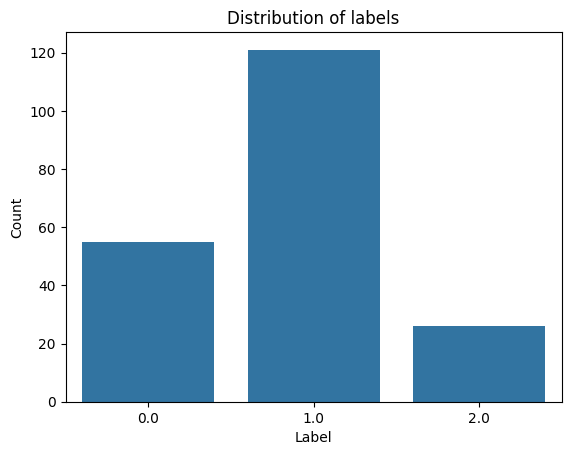

In [17]:
sns.countplot(x=y)
plt.title('Distribution of labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from keras import layers, models, optimizers, callbacks, regularizers

In [20]:
def get_model():
    input_layer = layers.Input(shape=(5, 240, 320, 1))

    # ----- Branch 1: Temporal convolution across 5 frames -----
    branch1 = layers.Conv3D(16, (3, 5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input_layer)
    branch1 = layers.MaxPooling3D((1, 2, 2))(branch1)
    branch1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(branch1)
    branch1 = layers.MaxPooling3D((1, 2, 2))(branch1)
    branch1 = layers.MaxPooling3D((2, 1, 1))(branch1)
    branch1 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(branch1)
    branch1 = layers.MaxPooling3D((1, 2, 2))(branch1)
    branch1 = layers.Conv3D(128, (5, 3, 3), activation='relu', padding='same')(branch1)
    branch1 = layers.GlobalAveragePooling3D()(branch1)

    # ----- Branch 2: Only the last frame -----
    last_frame = layers.Cropping3D(cropping=((4, 0), (0, 0), (0, 0)))(input_layer)
    last_frame = layers.Lambda(lambda x: x[:, 0, :, :, :])(last_frame)
    branch2 = layers.Conv2D(32, (5, 5), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(last_frame)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)
    branch2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(branch2)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)
    branch2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(branch2)
    branch2 = layers.MaxPooling2D((2, 2))(branch2)
    branch2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(branch2)
    branch2 = layers.GlobalAveragePooling2D()(branch2)

    # ----- Merge and Final Layers -----
    merged = layers.concatenate([branch1, branch2])
    output = layers.Dense(256, kernel_regularizer=regularizers.l2(0.001))(merged)
    output = layers.BatchNormalization()(output)
    output = layers.Activation('relu')(output)
    output = layers.Dropout(0.5)(output)
    output = layers.Dense(128)(output)
    output = layers.BatchNormalization()(output)
    output = layers.Activation('relu')(output)
    output = layers.Dropout(0.3)(output)
    output = layers.Dense(64, activation='relu')(output)
    output = layers.Dense(32, activation='relu')(output)
    output = layers.Dense(3, activation='softmax')(output)

    model = models.Model(inputs=input_layer, outputs=output)

    return model

In [21]:
model = get_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5, 240,    │          0 │ -                 │
│ (InputLayer)        │ 320, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cropping3d_1        │ (None, 1, 240,    │          0 │ input_layer_1[0]… │
│ (Cropping3D)        │ 320, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 5, 240,    │      1,216 │ input_layer_1[0]… │
│                     │ 320, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 240, 320,  │          0 │ cropping3d_1[0][… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_4     │ (None, 5, 120,    │          0 │ conv3d_4[0][0]    │
│ (MaxPooling3D)      │ 160, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 240, 320,  │        832 │ lambda_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 5, 120,    │     13,856 │ max_pooling3d_4[… │
│                     │ 160, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 120, 160,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_5     │ (None, 5, 60, 80, │          0 │ conv3d_5[0][0]    │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 120, 160,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_6     │ (None, 2, 60, 80, │          0 │ max_pooling3d_5[… │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 60, 80,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 2, 60, 80, │     55,360 │ max_pooling3d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 60, 80,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_7     │ (None, 2, 30, 40, │          0 │ conv3d_6[0][0]    │
│ (MaxPooling3D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 40,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 2, 30, 40, │    368,768 │ max_pooling3d_7[

 Total params: 970,979 (3.70 MB)

 Trainable params: 970,211 (3.70 MB)

 Non-trainable params: 768 (3.00 KB)

In [22]:
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
callback_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

In [24]:
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callback_list,
    shuffle=True,
    verbose=1,
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3962 - loss: 1.3955 - val_accuracy: 0.3171 - val_loss: 1.3593 - learning_rate: 1.0000e-04
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - accuracy: 0.5214 - loss: 1.2349 - val_accuracy: 0.3171 - val_loss: 1.3674 - learning_rate: 1.0000e-04
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.5363 - loss: 1.2522 - val_accuracy: 0.2927 - val_loss: 1.3526 - learning_rate: 1.0000e-04
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step - accuracy: 0.5856 - loss: 1.2161 - val_accuracy: 0.5122 - val_loss: 1.3342 - learning_rate: 1.0000e-04
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 278ms/step - accuracy: 0.6265 - loss: 1.1318 - val_accuracy: 0.5122 - val_loss: 1.3175 - learning_rate: 1.0000e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step - accuracy: 0.6380 - loss: 1.2296 - val_accuracy: 0.5122 - val_loss: 1.3102 - learning_rate: 1.0000e-04
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - accuracy: 0.6805 - loss: 1

In [25]:
model.save("COMP2211_PA2_Mini_AutoPilot.keras")

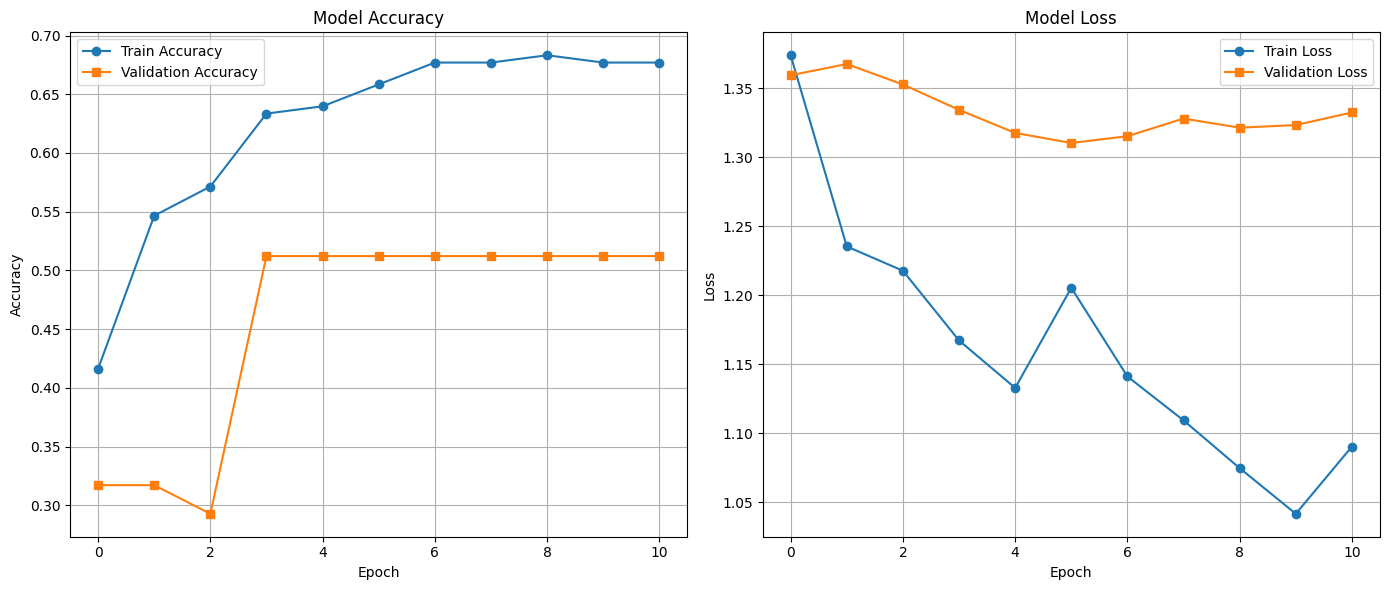

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
axes[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss plot
axes[1].plot(history.history['loss'], label='Train Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
Found 20 incorrect predictions. Displaying a few examples:


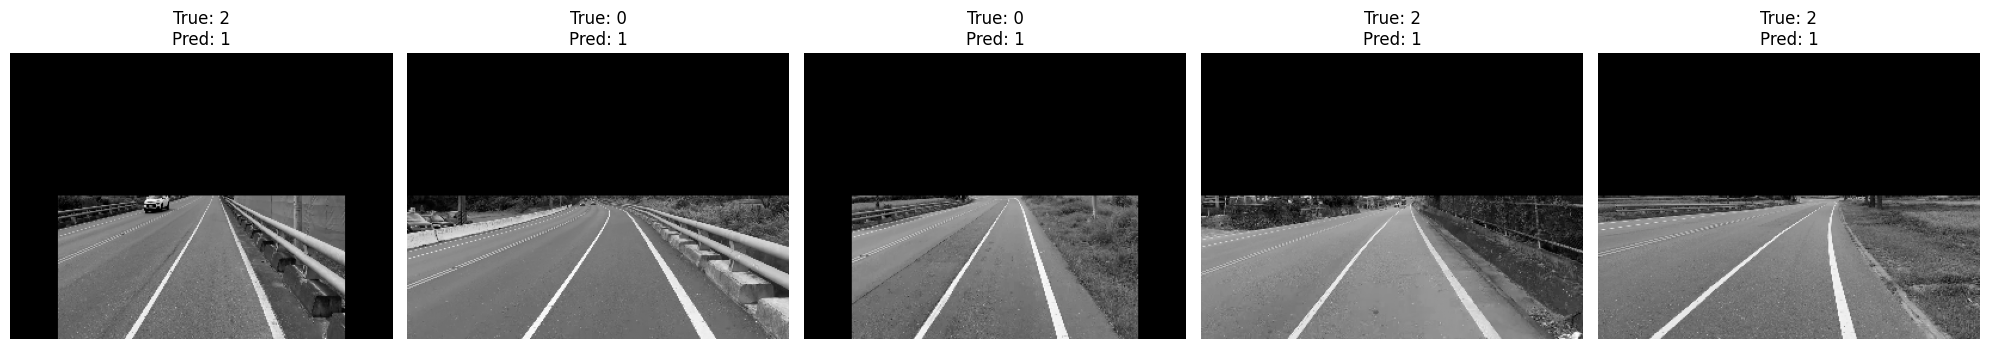

In [27]:
# Get model predictions on the validation set
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ensure y_val is integer type for comparison
y_val_int = y_val.astype(int)

# Find indices where predictions are incorrect
incorrect_indices = np.where(y_pred != y_val_int)[0]

if len(incorrect_indices) == 0:
    print("No incorrect predictions found in the validation set.")
else:
    print(f"Found {len(incorrect_indices)} incorrect predictions. Displaying a few examples:")
    
    # Select up to 5 random incorrect predictions to display
    num_to_display = min(5, len(incorrect_indices))
    selected_display_indices = np.random.choice(incorrect_indices, size=num_to_display, replace=False)
    
    fig, axes = plt.subplots(1, num_to_display, figsize=(num_to_display * 4, 4))
    if num_to_display == 1: # Ensure axes is iterable even for a single subplot
        axes = [axes]
        
    for i, data_idx in enumerate(selected_display_indices):
        # X_val has shape (num_samples, 5, 240, 320, 1)
        # We need the last frame: X_val[data_idx, -1, :, :, 0]
        last_frame = X_val[data_idx, -1, :, :, 0]
        
        true_label = y_val_int[data_idx]
        predicted_label = y_pred[data_idx]
        
        axes[i].imshow(last_frame, cmap='gray')
        axes[i].set_title(f"True: {true_label}\nPred: {predicted_label}")
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()